# Notebook Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install prince

  Obtaining dependency information for prince from https://files.pythonhosted.org/packages/ea/47/05a78e27a6c7f85b5e006169e4ddf27637867124ef841176f5e4f5ce7f88/prince-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 13.8 MB/s eta 0:00:00


In [3]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from prince import MCA
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes 

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

# Constants

In [4]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

# Step 1: Data Exploration and Preprocessing

### Load data

In [5]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df_full.drop([0], axis=0, inplace=True)
df_full.reset_index(drop=True, inplace=True)

df = df_full.sample(frac=0.5)
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
120735,908263,591724,MALE,71 SENATOR BOLLING CIRCLE,B3,4,3/9/13 0:00,3/9/13 0:00,NaN,B(Black),...,NO DATA ENTERED,11756.0,116944,4,B3,NaN,B(Black),21,5063,NO DATA ENTERED
37487,888645,571941,MALE,26 ANNUNCIATION RD,B2,3,7/27/12 0:00,7/27/12 0:00,YES,W(White),...,NO DATA ENTERED,10502.0,11631,16,YVSF,NaN,W(White),24,163,NO DATA ENTERED
144610,907719,591178,MALE,41 WINTER ST,A1,1,1/21/13 0:00,1/21/13 0:00,YES,M(Middle Eastern or East Indian),...,NO DATA ENTERED,8949.0,82861,1,A1,NaN,M(Middle Eastern or East Indian),22,4965,Boston
72811,775167,534916,MALE,00 AMHERST ST at BELGRADE AV,E5,11,8/11/07 0:00,8/11/07 0:00,YES,B(Black),...,NO DATA ENTERED,10402.0,99772,11,E5,NaN,B(Black),29,138,Brighton
33304,912127,595616,MALE,219 SHAWMUT AV,D4,8,3/22/13 0:00,3/22/13 0:00,YES,B(Black),...,NO DATA ENTERED,11312.0,75636,16,YVSF,NaN,B(Black),29,4124,NO DATA ENTERED


In [6]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (76115, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INCI

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76115 entries, 120735 to 84671
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   INCIDENT_UNIQUE_IDENTIFIER                    76115 non-null  object
 1   INCIDENT_UNIQUE_IDENTIFIER.1                  76115 non-null  object
 2   SUBJECT_GENDER                                76115 non-null  object
 3   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  76114 non-null  object
 4   LOCATION_DISTRICT                             76115 non-null  object
 5   LOCATION_DISTRICT.1                           76115 non-null  object
 6   INCIDENT_DATE                                 76115 non-null  object
 7   INCIDENT_TIME                                 76115 non-null  object
 8   SUBJECT_DETAILS                               65673 non-null  object
 9   SUBJECT_RACE                                  76115 non-null  object
 10

### Data Cleaning

In [8]:
# converting 'NO DATA ENTERED', 'UNKNOWN' values in columns to NaN values
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED", 'UNKNOWN', '0', 0, 'OTHER', 
                                    'OTHERS', 'DISCRIPTION',], value=np.nan, inplace=True)

In [9]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                          0
INCIDENT_UNIQUE_IDENTIFIER.1                        0
SUBJECT_GENDER                                    129
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        1
LOCATION_DISTRICT                                  17
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
INCIDENT_TIME                                       0
SUBJECT_DETAILS                                 11260
SUBJECT_RACE                                     3386
SUBJECT_DETAILS.1                                6920
SUBJECT_DETAILS.2                               12730
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
SEARCH_CONDUCTED                                65681
SEARCH_REASON                                   58227
INCIDENT_REASON                                 23488
INCIDENT_REASON.1                                   0


In [10]:
# dropping columns where the NaN values were more than 4000
for feature in df.columns:
    if df[feature].isnull().sum() > 12000:
        df.drop([feature], axis=1, inplace=True)
        
# dropping columns where the unique values were more than 1000
for feature in df.columns:
    
    if feature != 'LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION' and feature != 'INCIDENT_DATE':
        
        if len(df[feature].unique()) > 2500:
            df.drop([feature], axis=1, inplace=True)

In [11]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE
120735,MALE,71 SENATOR BOLLING CIRCLE,B3,4,3/9/13 0:00,3/9/13 0:00,NaN,B(Black),I,NO,"INVESTIGATE, PERSON",F,11756.0,4,B3,B(Black),21
37487,MALE,26 ANNUNCIATION RD,B2,3,7/27/12 0:00,7/27/12 0:00,YES,W(White),OF,NO,"INVESTIGATE, PERSON",F,10502.0,16,YVSF,W(White),24
144610,MALE,41 WINTER ST,A1,1,1/21/13 0:00,1/21/13 0:00,YES,M(Middle Eastern or East Indian),IO,NO,TRESPASSING,NaN,8949.0,1,A1,M(Middle Eastern or East Indian),22
72811,MALE,00 AMHERST ST at BELGRADE AV,E5,11,8/11/07 0:00,8/11/07 0:00,YES,B(Black),IO,NO,"INVESTIGATE, MV",F,10402.0,11,E5,B(Black),29
33304,MALE,219 SHAWMUT AV,D4,8,3/22/13 0:00,3/22/13 0:00,YES,B(Black),O,NO,"INVESTIGATE, PERSON",F,11312.0,16,YVSF,B(Black),29


In [12]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    129
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        1
LOCATION_DISTRICT                                  17
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
INCIDENT_TIME                                       0
SUBJECT_DETAILS                                 11260
SUBJECT_RACE                                     3386
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
INCIDENT_REASON.1                                   0
DISPOSITION                                      4516
OFFICER_SUPERVISOR                               8307
OFFICER_ASSIGNMENT                                  0
OFFICER_ASSIGNMENT.1                              244
OFFICER_RACE                                     3386
OFFICER_AGE                                       102
dtype: int64


In [13]:
df.shape

(76115, 17)

In [14]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE
120735,MALE,71 SENATOR BOLLING CIRCLE,B3,4,3/9/13 0:00,3/9/13 0:00,NaN,B(Black),I,NO,"INVESTIGATE, PERSON",F,11756.0,4,B3,B(Black),21
37487,MALE,26 ANNUNCIATION RD,B2,3,7/27/12 0:00,7/27/12 0:00,YES,W(White),OF,NO,"INVESTIGATE, PERSON",F,10502.0,16,YVSF,W(White),24
144610,MALE,41 WINTER ST,A1,1,1/21/13 0:00,1/21/13 0:00,YES,M(Middle Eastern or East Indian),IO,NO,TRESPASSING,NaN,8949.0,1,A1,M(Middle Eastern or East Indian),22
72811,MALE,00 AMHERST ST at BELGRADE AV,E5,11,8/11/07 0:00,8/11/07 0:00,YES,B(Black),IO,NO,"INVESTIGATE, MV",F,10402.0,11,E5,B(Black),29
33304,MALE,219 SHAWMUT AV,D4,8,3/22/13 0:00,3/22/13 0:00,YES,B(Black),O,NO,"INVESTIGATE, PERSON",F,11312.0,16,YVSF,B(Black),29


In [15]:
df.drop([ 'UNKNOWN_FIELD_TYPE.1', 'UNKNOWN_FIELD_TYPE', 'LOCATION_DISTRICT.1', 'INCIDENT_TIME',
         'OFFICER_ASSIGNMENT', 'DISPOSITION', 'OFFICER_SUPERVISOR', 'OFFICER_RACE'], axis=1, inplace=True)

In [16]:
df.shape

(76115, 9)

In [17]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE
120735,MALE,71 SENATOR BOLLING CIRCLE,B3,3/9/13 0:00,NaN,B(Black),"INVESTIGATE, PERSON",B3,21
37487,MALE,26 ANNUNCIATION RD,B2,7/27/12 0:00,YES,W(White),"INVESTIGATE, PERSON",YVSF,24
144610,MALE,41 WINTER ST,A1,1/21/13 0:00,YES,M(Middle Eastern or East Indian),TRESPASSING,A1,22
72811,MALE,00 AMHERST ST at BELGRADE AV,E5,8/11/07 0:00,YES,B(Black),"INVESTIGATE, MV",E5,29
33304,MALE,219 SHAWMUT AV,D4,3/22/13 0:00,YES,B(Black),"INVESTIGATE, PERSON",YVSF,29


In [18]:
df.duplicated().value_counts()

False    74499
True      1616
Name: count, dtype: int64

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    127
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        1
LOCATION_DISTRICT                                  17
INCIDENT_DATE                                       0
SUBJECT_DETAILS                                 11041
SUBJECT_RACE                                     3332
INCIDENT_REASON.1                                   0
OFFICER_ASSIGNMENT.1                              243
OFFICER_AGE                                       102
dtype: int64


In [21]:
# Handling missing values

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

SUBJECT_GENDER                                  0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_DISTRICT                               0
INCIDENT_DATE                                   0
SUBJECT_DETAILS                                 0
SUBJECT_RACE                                    0
INCIDENT_REASON.1                               0
OFFICER_ASSIGNMENT.1                            0
OFFICER_AGE                                     0
dtype: int64

### Data Preprocessing

In [22]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%B')

df.drop(['INCIDENT_DATE'], axis=1, inplace=True)

In [23]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,71 SENATOR BOLLING CIRCLE,B3,YES,B(Black),"INVESTIGATE, PERSON",B3,21,2013,March
1,MALE,26 ANNUNCIATION RD,B2,YES,W(White),"INVESTIGATE, PERSON",YVSF,24,2012,July
2,MALE,41 WINTER ST,A1,YES,M(Middle Eastern or East Indian),TRESPASSING,A1,22,2013,January
3,MALE,00 AMHERST ST at BELGRADE AV,E5,YES,B(Black),"INVESTIGATE, MV",E5,29,2007,August
4,MALE,219 SHAWMUT AV,D4,YES,B(Black),"INVESTIGATE, PERSON",YVSF,29,2013,March


In [24]:
# replace weird years
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2011) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2011) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [25]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2012    18798
2011    17215
2013    17094
2014    16736
2015     4656
Name: count, dtype: int64

In [26]:
list_ = df['INCIDENT_REASON.1'].unique().tolist()

dict_ = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    '209A':  ['209A'],
    'ASSAULT': ['ASSAULT', 'A&B'],
    'SEXUAL OFFENDER': ['SEXUAL', 'OFFENDER', 'SEX-ASSAULT', 'RAPE', 'SEX'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['PUBLIC', 'DRINKING', 'ALCOHOL'],
    'ABDW': ['ABDW', 'A D/W'],
    'B&E': ['B&E'], 
    'MV': ['MV', 'M/V'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'],
    'DISTURBING': ['DISTURBING', 'PEACE', 'LOUD', 'PARTY', 'DISTURBANCE', 'NOISYHOUSE', 'NOISE'], 
    'FIREARM': ['FIREARM', 'FIRE'], 
    'HIT & RUN': ['HIT', 'RUN'],
    'SEARCH WARRANT': ['SEARCH', 'WARRANT', 'WARRANTS'],
    'THREATS': ['THREATS', 'THREAT'],
    'CITY ORDINANCES': ['CITY', 'ORDINANCES'],
    'MISSING PERSON': ['MISSING'],
    'DISORDERLY': ['DISORDERLY', 'UNNATURAL', 'LACIVIOUS'],
    'PROPERTY DAMAGE': ['PROPERTY', 'DAMAGE'], 
    'HARASSMENT': ['HARASSMENT']
}

for item in list_:
    for key, values in dict_.items():            
        if any(value in item for value in values):
            df['INCIDENT_REASON.1'].replace(item, value=key, inplace=True)                 
            break 

# Find values with counts less than or equal to 4
infrequent_values = df['INCIDENT_REASON.1'].value_counts()[df['INCIDENT_REASON.1'].value_counts() <= 4].index

# Replace those infrequent values with 'OTHERS'
df['INCIDENT_REASON.1'] = df['INCIDENT_REASON.1'].replace(infrequent_values, 'OTHERS')

In [27]:
len(df['INCIDENT_REASON.1'].value_counts())

47

In [28]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 15) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 15) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

# Define a dictionary of age group labels
age_groups = {
    '15-19': range(15, 20),
    '20-29': range(20, 30),
    '30-39': range(30, 40),
    '40-49': range(40, 50),
    '50-59': range(50, 60),
    '60-69': range(60, 70),
    '70+': range(70, 110),  # Assuming 70 and above
}

# Iterate through the age group labels and replace values in the DataFrame
for age_group, age_range in age_groups.items():
    df['OFFICER_AGE'] = df['OFFICER_AGE'].replace(age_range, age_group)

In [29]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,71 SENATOR BOLLING CIRCLE,B3,YES,B(Black),"INVESTIGATE, PERSON",B3,20-29,2013,March
1,MALE,26 ANNUNCIATION RD,B2,YES,W(White),"INVESTIGATE, PERSON",YVSF,20-29,2012,July
2,MALE,41 WINTER ST,A1,YES,M(Middle Eastern or East Indian),TRESPASSING,A1,20-29,2013,January
3,MALE,00 AMHERST ST at BELGRADE AV,E5,YES,B(Black),MV,E5,20-29,2013,August
4,MALE,219 SHAWMUT AV,D4,YES,B(Black),"INVESTIGATE, PERSON",YVSF,20-29,2013,March


In [30]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()

    match = re.search(r'[^0-9]+$', modified_address)
    if match:
        old_street_name = address
        new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
        street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

# Find values with counts less than or equal to 1
infrequent_values = df['LOCATION_STREET_ADDRESS'].value_counts()[df['LOCATION_STREET_ADDRESS'].value_counts() <= 1].index

# Replace those infrequent values with 'OTHERS'
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_STREET_ADDRESS'].replace(infrequent_values, 'OTHERS')

In [31]:
df.drop(['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,MALE,B3,YES,B(Black),"INVESTIGATE, PERSON",B3,20-29,2013,March,SENATOR BOLLING CIRCLE
1,MALE,B2,YES,W(White),"INVESTIGATE, PERSON",YVSF,20-29,2012,July,ANNUNCIATION RD
2,MALE,A1,YES,M(Middle Eastern or East Indian),TRESPASSING,A1,20-29,2013,January,WINTER ST
3,MALE,E5,YES,B(Black),MV,E5,20-29,2013,August,AMHERST ST
4,MALE,D4,YES,B(Black),"INVESTIGATE, PERSON",YVSF,20-29,2013,March,SHAWMUT AV


In [32]:
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in SUBJECT_GENDER column: 2
Number of unique values in LOCATION_DISTRICT column: 21
Number of unique values in SUBJECT_DETAILS column: 2
Number of unique values in SUBJECT_RACE column: 6
Number of unique values in INCIDENT_REASON.1 column: 47
Number of unique values in OFFICER_ASSIGNMENT.1 column: 23
Number of unique values in OFFICER_AGE column: 7
Number of unique values in INCIDENT_YEAR column: 5
Number of unique values in INCIDENT_MONTH column: 12
Number of unique values in LOCATION_STREET_ADDRESS column: 2105


In [33]:
df.shape

(74499, 10)

### Data Encoding

In [34]:
df.dtypes

SUBJECT_GENDER             object
LOCATION_DISTRICT          object
SUBJECT_DETAILS            object
SUBJECT_RACE               object
INCIDENT_REASON.1          object
OFFICER_ASSIGNMENT.1       object
OFFICER_AGE                object
INCIDENT_YEAR              object
INCIDENT_MONTH             object
LOCATION_STREET_ADDRESS    object
dtype: object

In [35]:
encoded_df = df.copy()

for feature in encoded_df.columns:
    encoded_df[feature] = encoded_df[feature].astype(str)

label_encoder = LabelEncoder()
for column in encoded_df.columns:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

In [36]:
encoded_df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,1,5,1,1,25,5,1,2,7,1691
1,1,4,1,5,25,22,1,1,5,72
2,1,0,1,4,41,0,1,2,4,2052
3,1,17,1,1,30,17,1,2,1,61
4,1,13,1,1,25,22,1,2,7,1697


# Step 2: Exploratory Data Analysis (EDA)

### Gender and Race Distribution

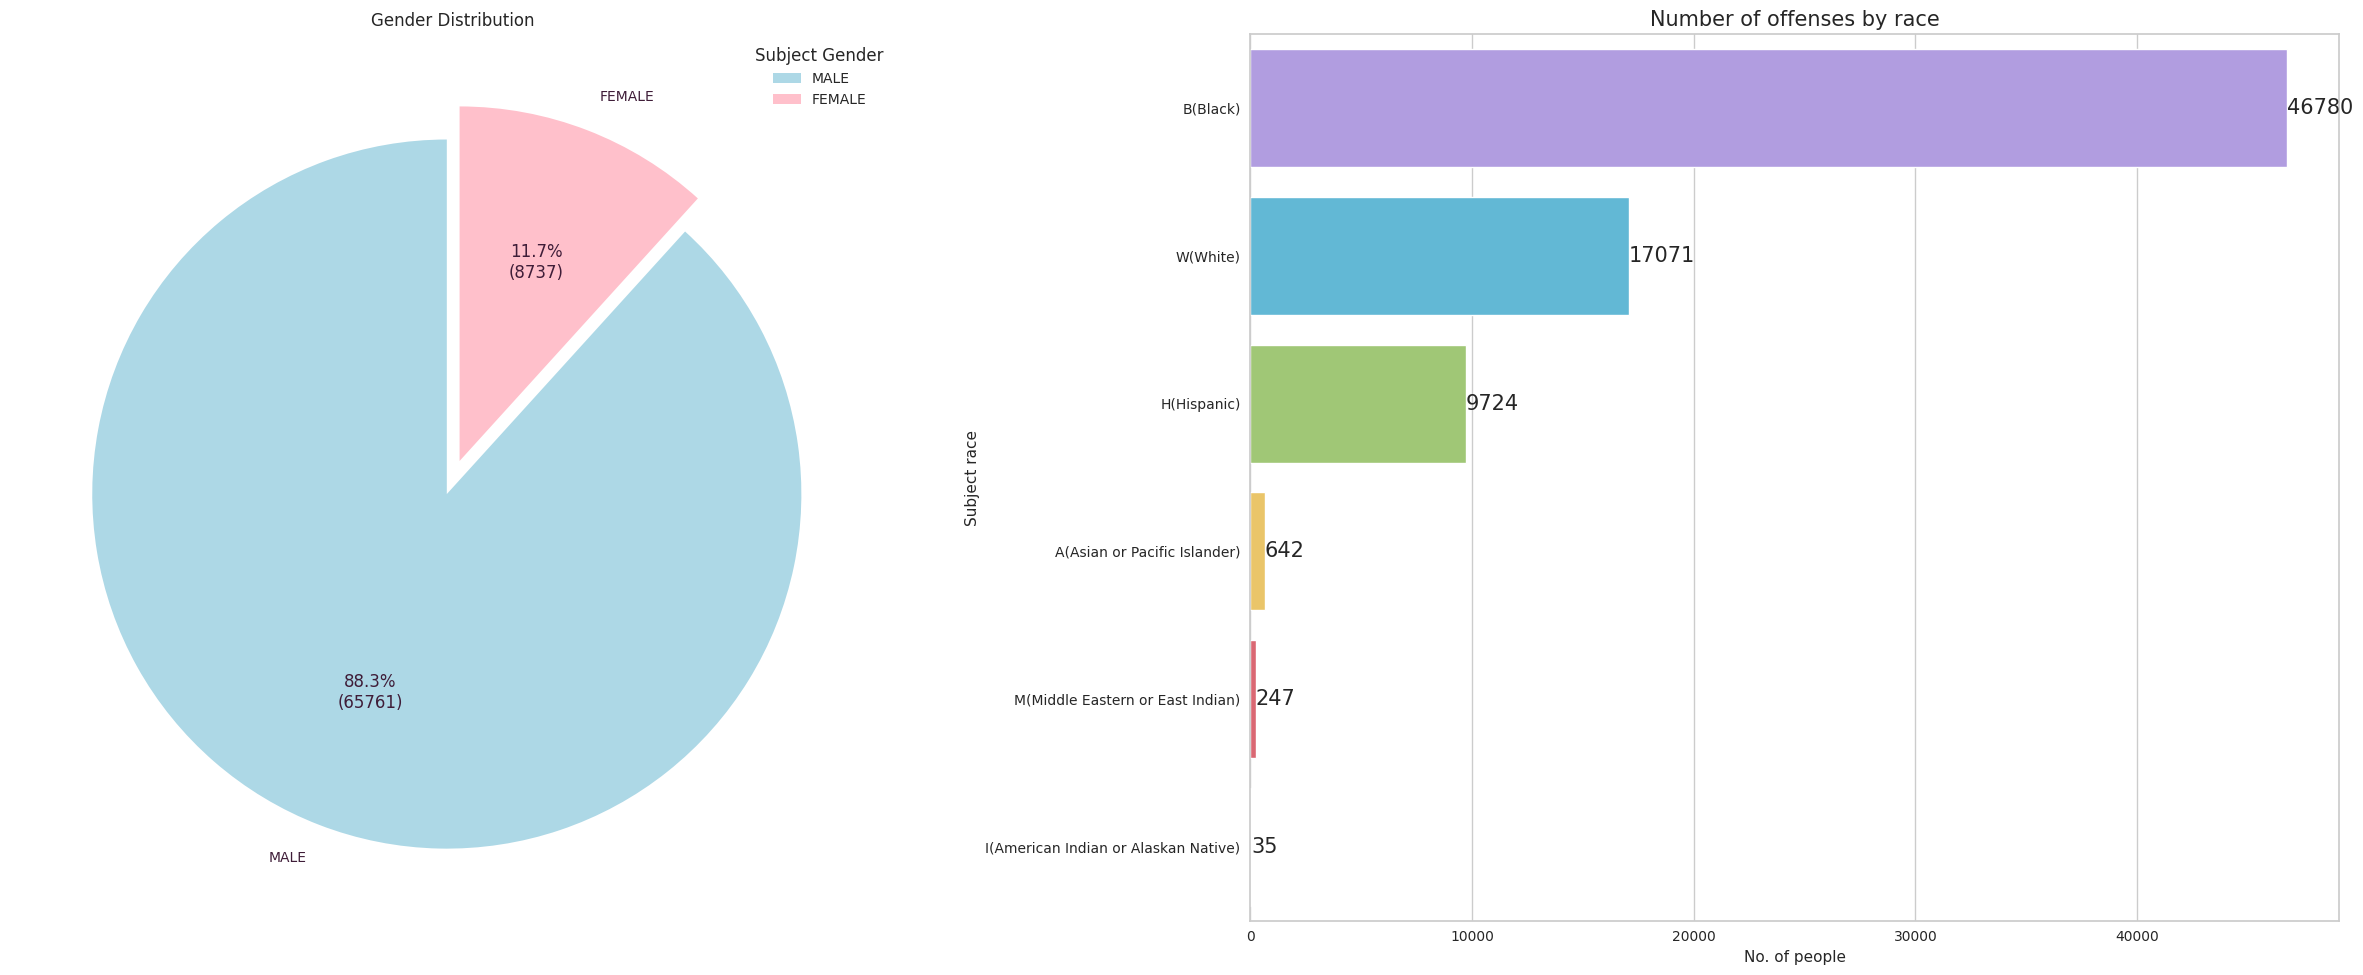

In [37]:
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']

colors = ['lightblue', 'pink']
explode = (0.05, 0.05)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Creating the bar chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order, palette=colors) 

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offenses by race')
plt.ylabel('Subject race')
plt.xlabel('No. of people')

# Show plots
plt.tight_layout()
plt.show()

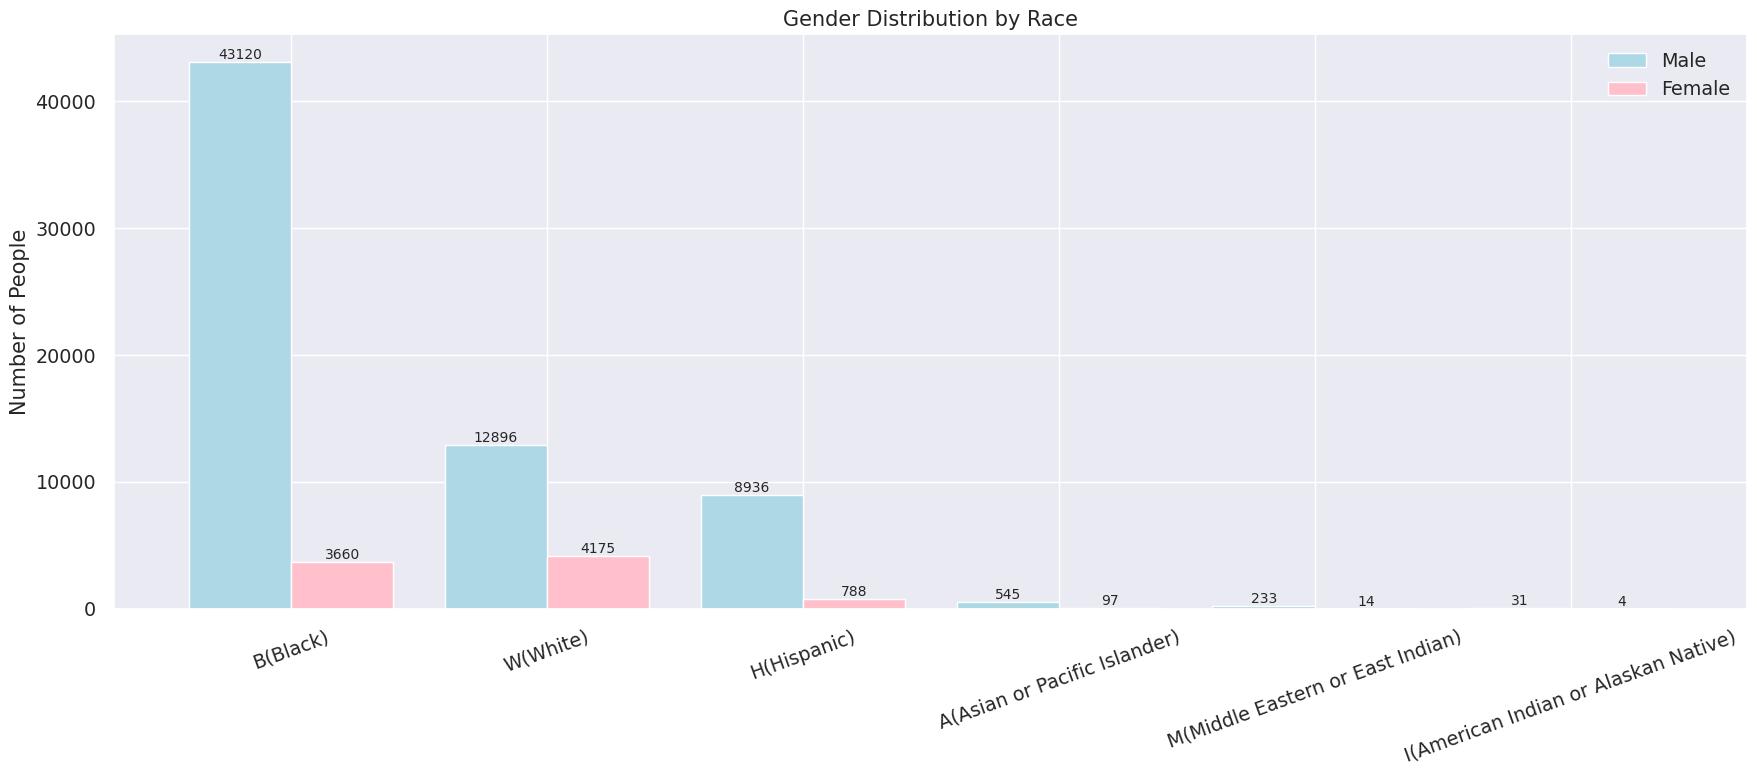

In [38]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().index

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
male_counts = male['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)
female_counts = female['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, male_counts, width, color=colors[0], label='Male')
plt.bar(x + width/2, female_counts, width, color=colors[1], label='Female')

# Annotate the bars with their values
for i in range(len(race_to_plot)):
    plt.text(x[i] - width/2, male_counts[i], str(male_counts[i]), ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, female_counts[i], str(female_counts[i]), ha='center', va='bottom', fontsize=10)

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Years and Months

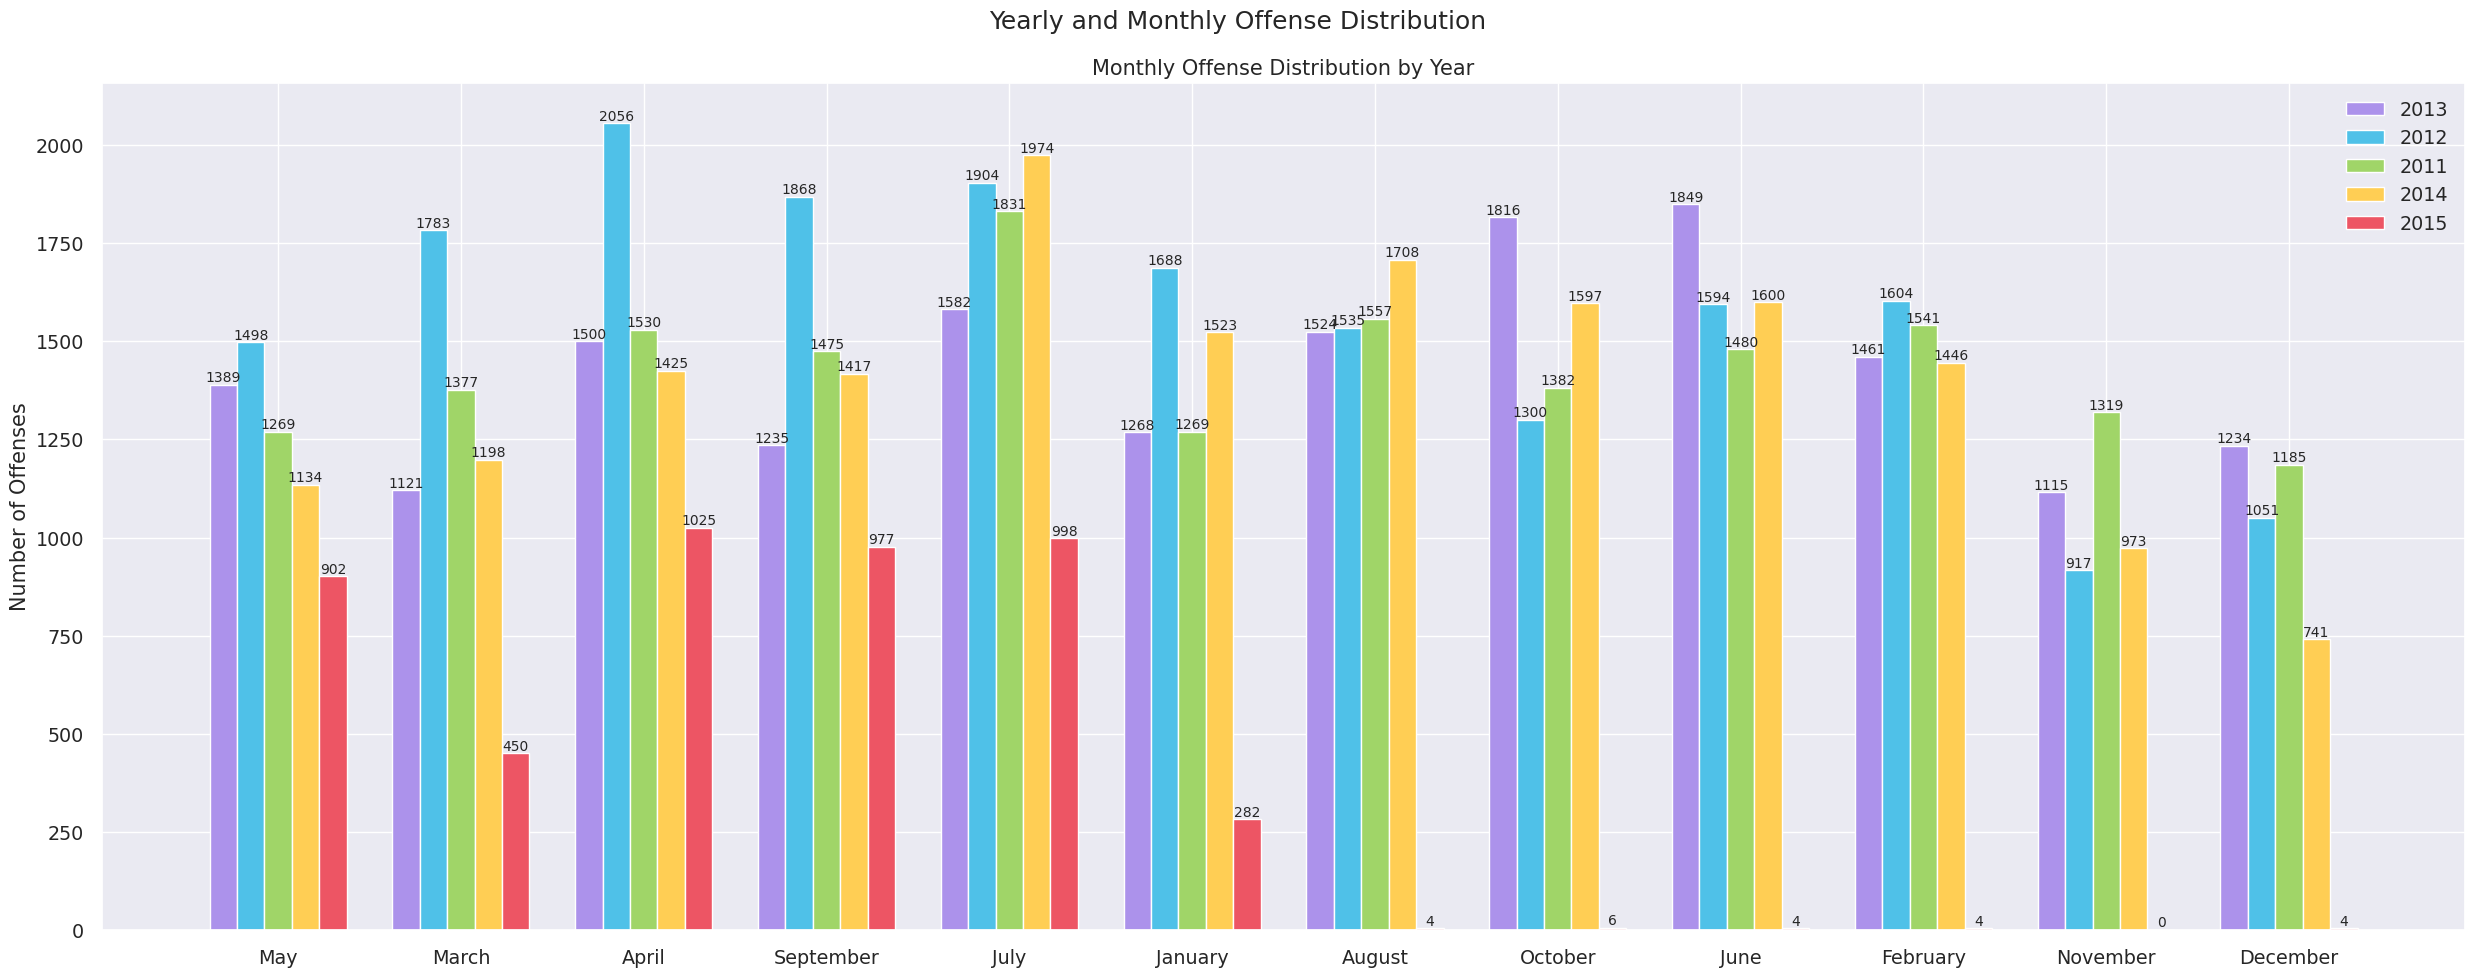

In [39]:
# Get unique years in your data
years_to_plot = df['INCIDENT_YEAR'].unique()

# Create a mapping from month names to their numeric values
month_name_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# An empty list to store monthly counts for each year
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].map(month_name_to_number)  # Map month names to numbers
    value_counts = value.value_counts()

    # Create an empty list to store the counts for all 12 months
    monthly_counts = [0] * 12
    
    # Fill in the counts for the months that exist
    for month, count in value_counts.items():
        monthly_counts[month - 1] = count  # Subtract 1 to adjust for zero-based indexing

    values.append(monthly_counts)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(25, 10))
for n in range(len(years_to_plot)):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

# Annotate the bars with their values
for n in range(len(years_to_plot)):
    for i in range(12):
        plt.text(x[i] + (n - 2) * width, values[n][i], str(values[n][i]), ha='center', va='bottom', fontsize=10)

order = df['INCIDENT_MONTH'].value_counts().index
plt.xticks(x, order)
plt.ylabel("Number of Offenses")
plt.legend(years_to_plot)  # Use the extracted unique years
plt.title("Monthly Offense Distribution by Year")

# Adding an overall title to the entire figure
plt.suptitle("Yearly and Monthly Offense Distribution")

# Show plots
plt.tight_layout()
plt.show()

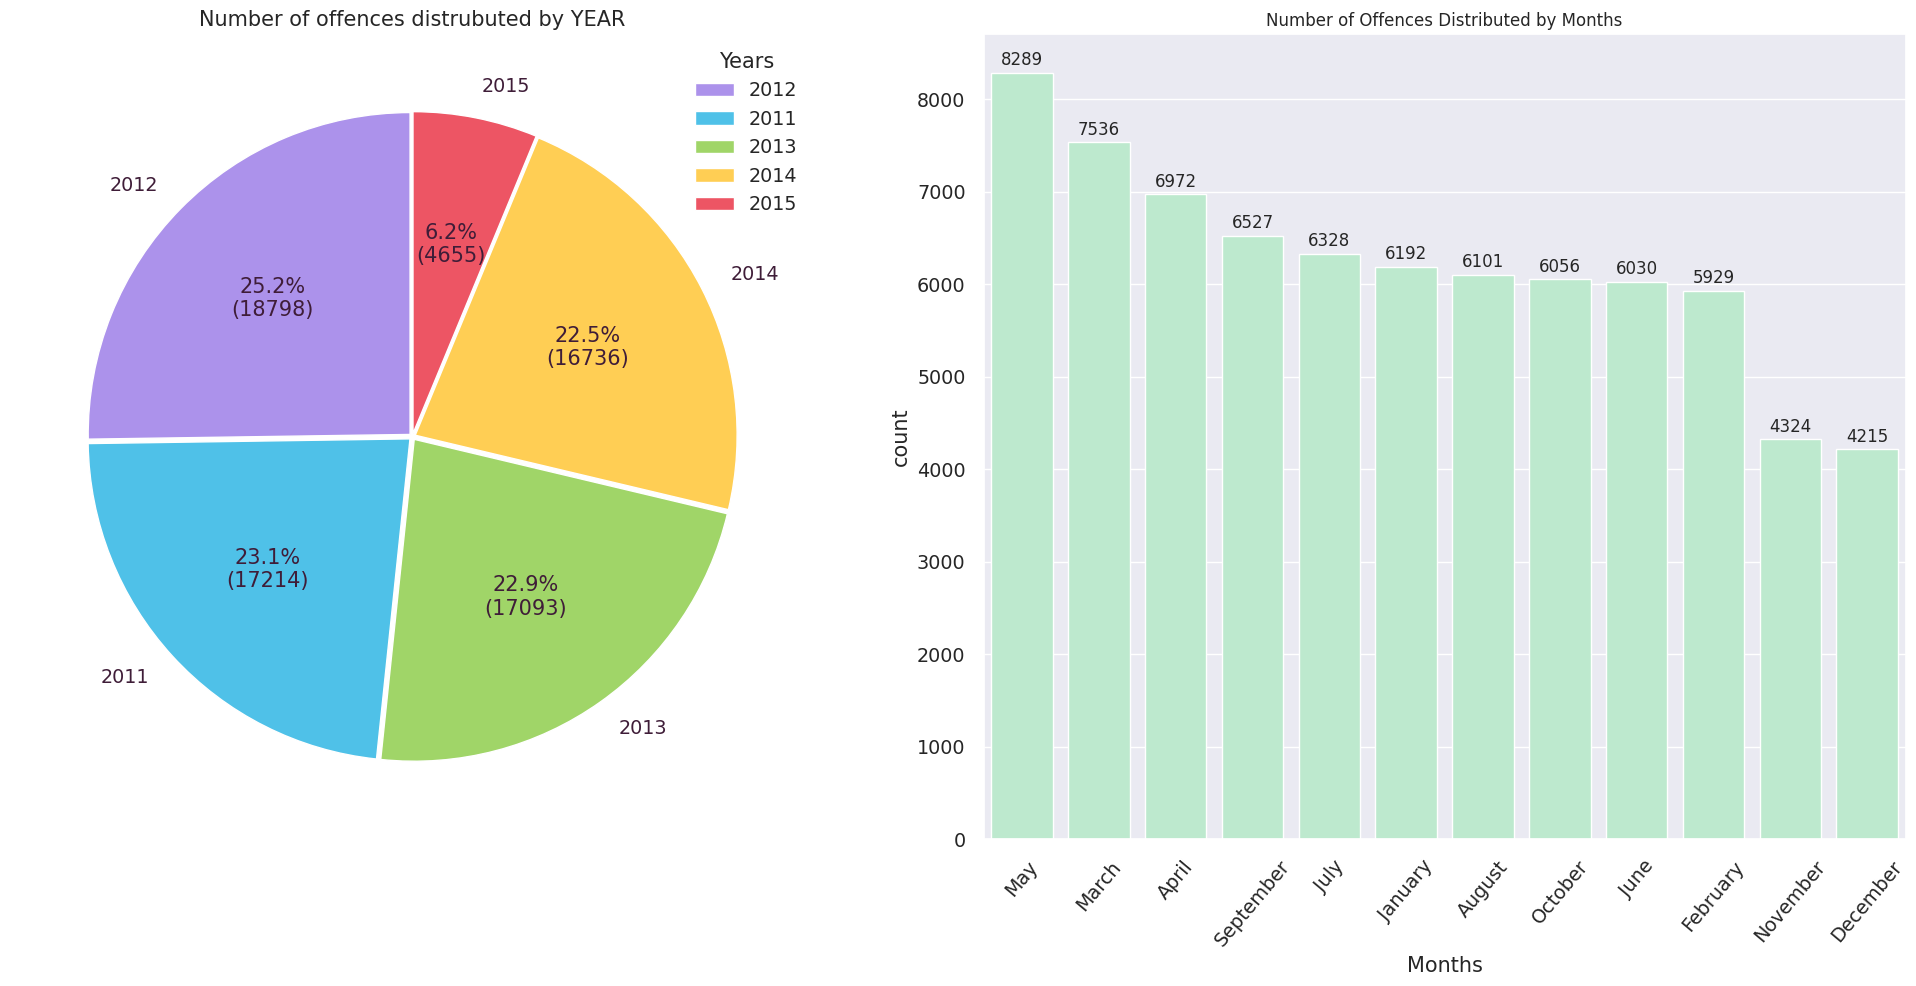

In [40]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index]
labels = df['INCIDENT_YEAR'].value_counts().index

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.01, 0.01, 0.01, 0.01, 0.01) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, autopct=lambda pct: func(pct, data), 
        startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='INCIDENT_MONTH', order=order, color='#B5F1CC') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

### Number of Offences Distributed by Location

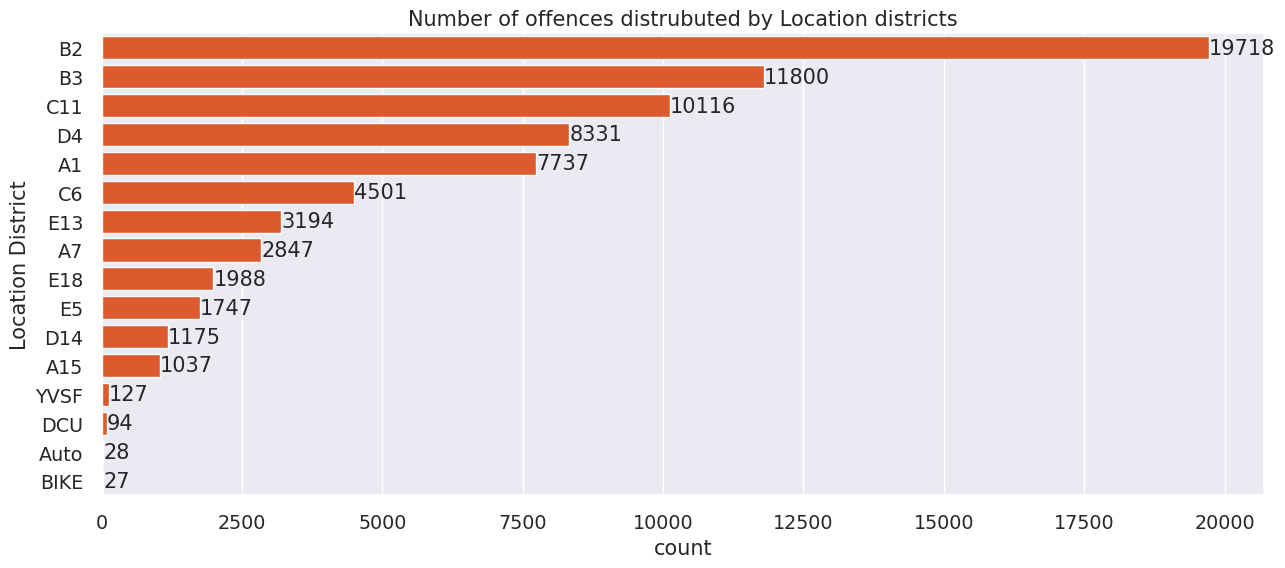

In [41]:
# Bar chart 1: Location district
plt.figure(figsize=(15, 6))
order = df['LOCATION_DISTRICT'].value_counts().index[0:16]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by Location districts')
plt.ylabel('Location District')

plt.show()

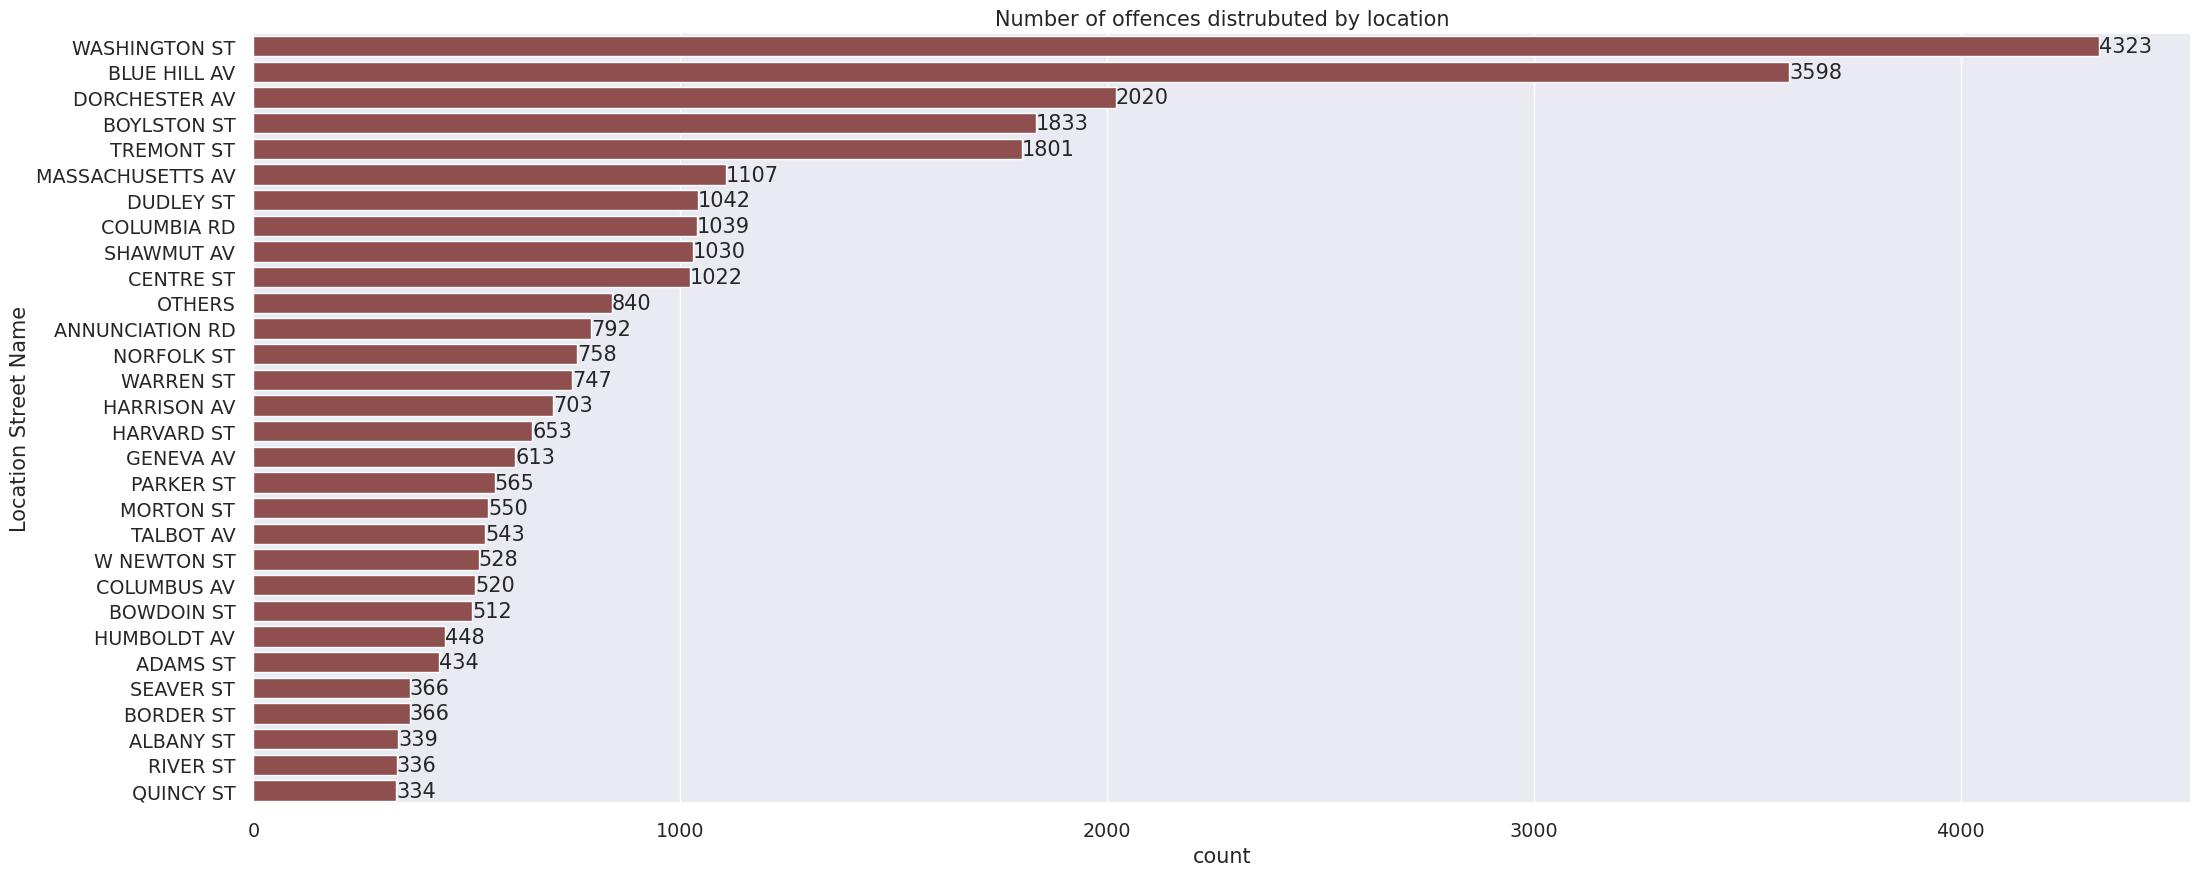

In [42]:
# Bar chart: Location
plt.figure(figsize=(25, 10))
order = df['LOCATION_STREET_ADDRESS'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_STREET_ADDRESS'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location Street Name')

plt.show()

### Officer Related Information

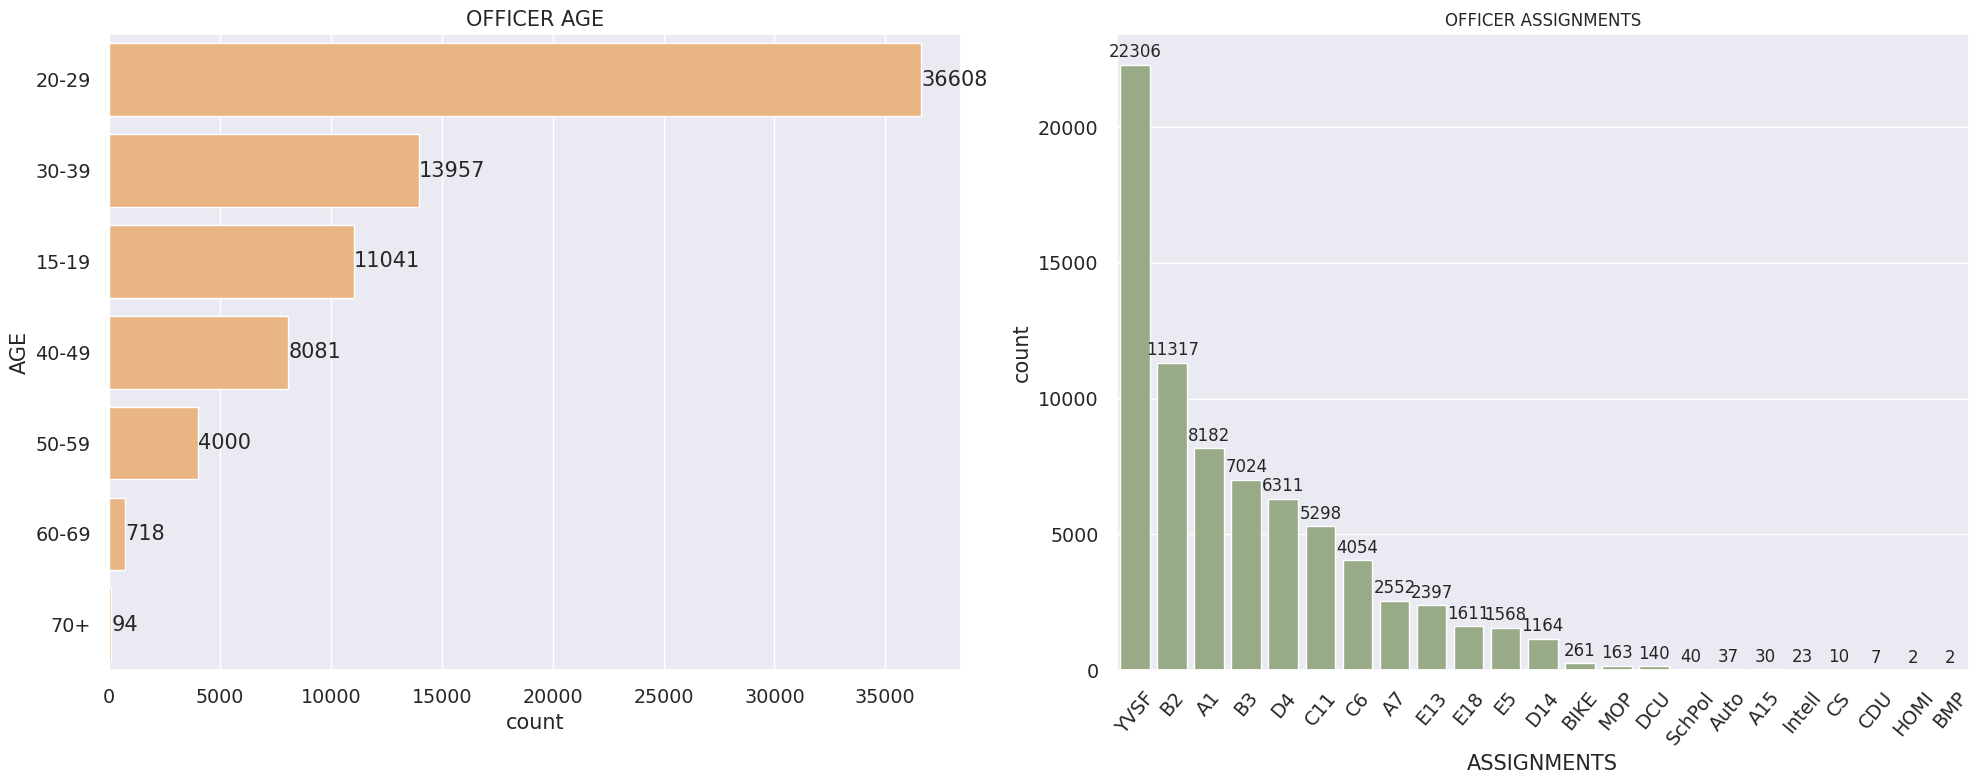

In [43]:
# Creating data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
order = df['OFFICER_AGE'].value_counts().index[:12]
ax = sns.countplot(y=df['OFFICER_AGE'], order=order, color='#F9B572')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('AGE')
plt.title("OFFICER AGE")

# Bat chart
plt.subplot(1, 2, 2)
order = df['OFFICER_ASSIGNMENT.1'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='OFFICER_ASSIGNMENT.1', order=order, color='#99B080') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('OFFICER ASSIGNMENTS')
plt.xlabel('ASSIGNMENTS')

plt.tight_layout() 
plt.show()

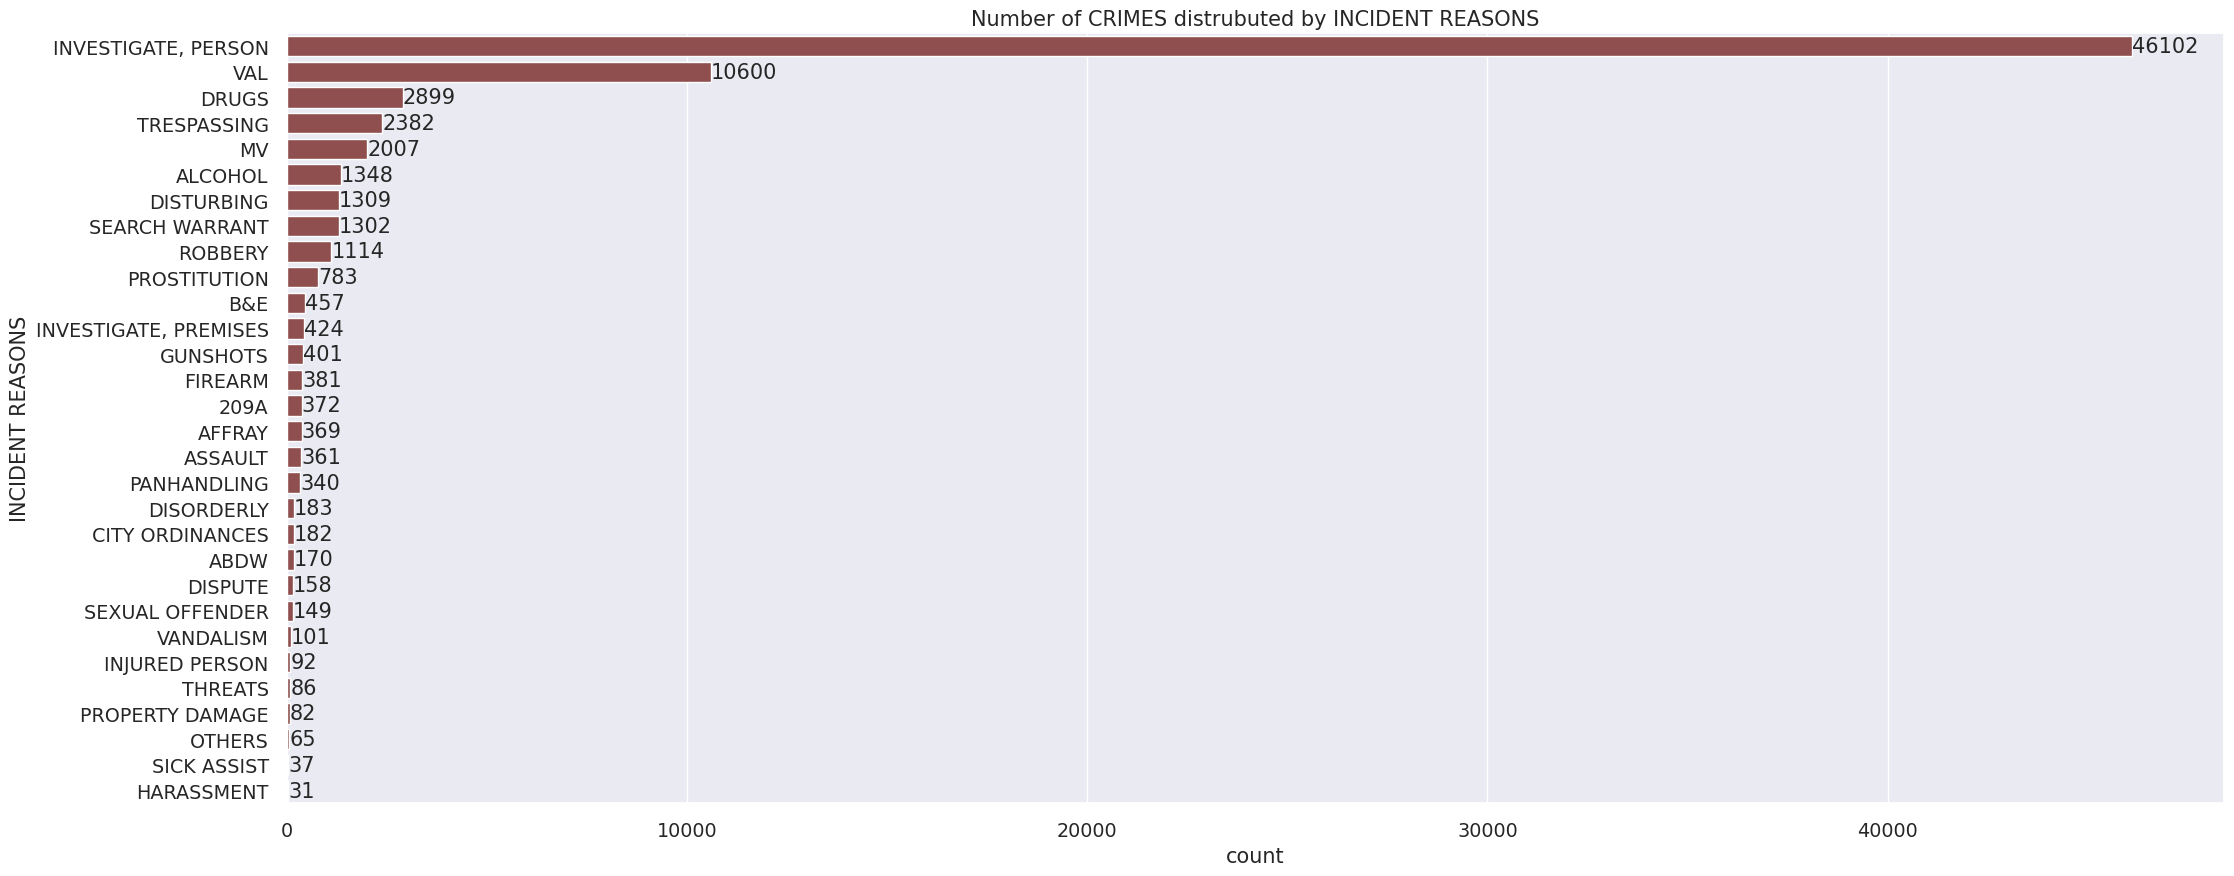

In [44]:
# Bar chart 1: Location
plt.figure(figsize=(25, 10))
order = df['INCIDENT_REASON.1'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['INCIDENT_REASON.1'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of CRIMES distrubuted by INCIDENT REASONS')
plt.ylabel('INCIDENT REASONS')

plt.show()

# Step 3: Clustering

### Choosing the Number of clusters k

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 409950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 409950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 409950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 409950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 409950.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14823, cost: 385963.0
Run 1, iteration: 2/100, moves: 1769, cost: 385963.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12604, cost: 381466.0
Run 2, 

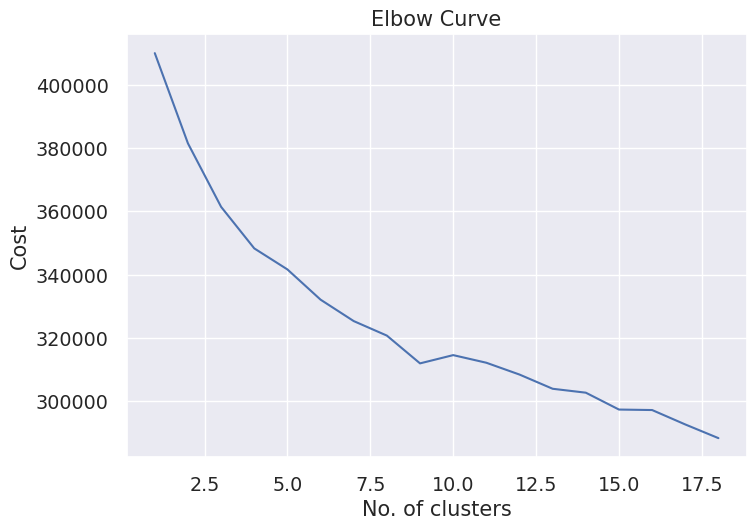

In [45]:
# Elbow curve to find optimal K 
cost = [] 
K = range(1, 19) 
for k in list(K): 
    kmode = KModes(n_clusters=k, init='random', n_init=5, verbose=2) 
    kmode.fit_predict(encoded_df.values) 
    cost.append(kmode.cost_) 
      
plt.plot(K, cost, 'x-') 
plt.xlabel('No. of clusters') 
plt.ylabel('Cost') 
plt.title('Elbow Curve') 
plt.show()

### K-mode clustering

In [46]:
# KMode clustering

optimal_k = 8

kmode = KModes(n_clusters=optimal_k, init='random', n_init=5, verbose=2) 
clusters = kmode.fit_predict(encoded_df.values) 
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 27342, cost: 336072.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 23414, cost: 337941.0
Run 2, iteration: 2/100, moves: 151, cost: 337941.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 20299, cost: 326008.0
Run 3, iteration: 2/100, moves: 9318, cost: 322392.0
Run 3, iteration: 3/100, moves: 372, cost: 322392.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 20938, cost: 333761.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 14258, cost: 333977.0
Best run was number 3


array([4, 4, 0, ..., 2, 4, 0], dtype=uint16)

# Step 5: Cluster Analysis

### Analyzing clusters characteristics

In [47]:
# Getting cluster centroids from the fitted model
cluster_centers = kmode.cluster_centroids_

cluster_characteristics = []

for i in range(optimal_k):    
    cluster_data = encoded_df.values[clusters == i]
    cluster_size = len(cluster_data)
    cluster_center = cluster_centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))
    
    cluster_characteristics.append({
        "Cluster": i + 1,        
        "Size": cluster_size,
        "Avg Distance": avg_distance,    
    })

cluster_characteristics

[{'Cluster': 1, 'Size': 14910, 'Avg Distance': 919.7186048369795},
 {'Cluster': 2, 'Size': 14689, 'Avg Distance': 888.1809328505202},
 {'Cluster': 3, 'Size': 9893, 'Avg Distance': 801.1818227917372},
 {'Cluster': 4, 'Size': 6247, 'Avg Distance': 781.351503507003},
 {'Cluster': 5, 'Size': 15232, 'Avg Distance': 788.564032410479},
 {'Cluster': 6, 'Size': 5036, 'Avg Distance': 516.6940610549074},
 {'Cluster': 7, 'Size': 4296, 'Avg Distance': 550.8810950404302},
 {'Cluster': 8, 'Size': 4196, 'Avg Distance': 803.2155807554406}]

### Silhouette Score, Davies-Bouldin Index, Variance Ratio Criterion, Within-Cluster Sum of Squares (WCSS)

In [48]:
silhouette_avg = silhouette_score(encoded_df.values, clusters)
print('Silhouette Score:', round(silhouette_avg, 4))

db_index = davies_bouldin_score(encoded_df.values, clusters)
print('Davies-Bouldin Index:', round(db_index, 4))

ch_score = calinski_harabasz_score(encoded_df.values, clusters)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', round(ch_score, 4))

Silhouette Score: -0.0899
Davies-Bouldin Index: 63.8358
Calinski-Harabasz Index (Variance Ratio Criterion): 87.4729


### Cluster Visualization

In [49]:
df['CLUSTERS'] = clusters

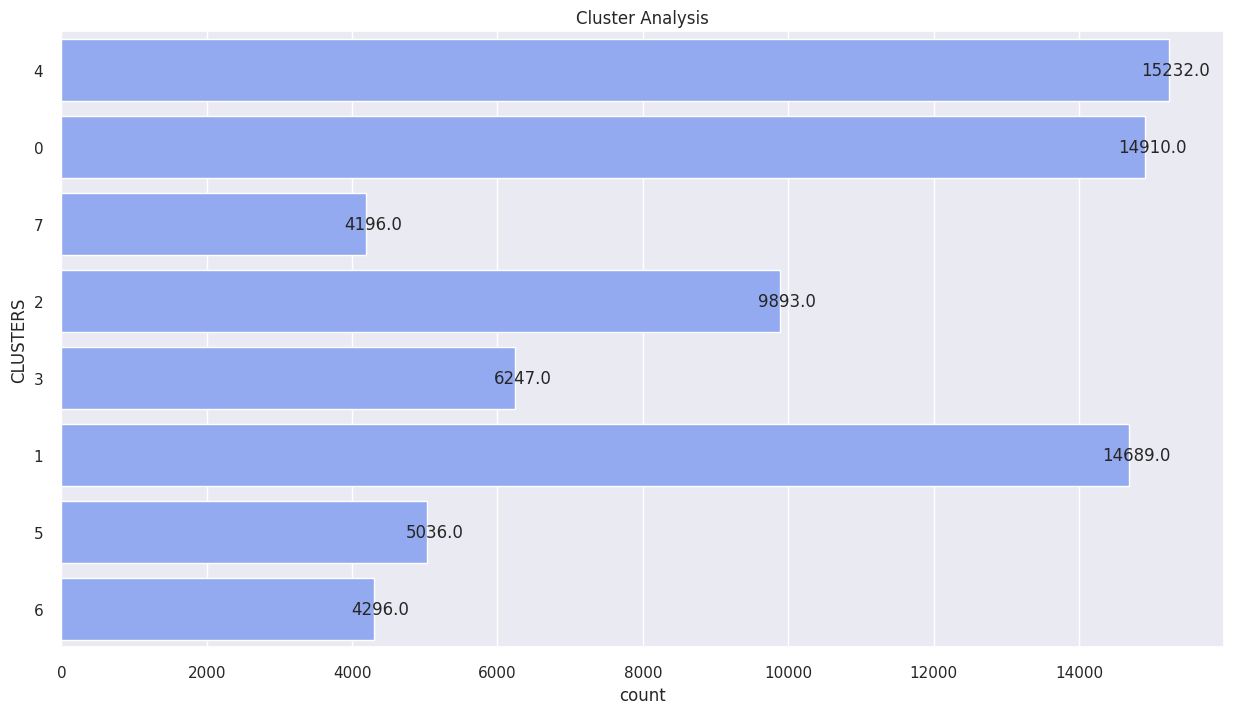

In [50]:
data = [len(df[df['CLUSTERS'] == feature]) for feature in df['CLUSTERS'].value_counts().index]
clusters = df['CLUSTERS'].unique()
labels = [f'CLUSTER: {clusters[i]}' for i in range(len(clusters))]

plt.figure(figsize=(15, 8))
sns.set(font_scale=1)
ax = sns.countplot(y='CLUSTERS', data=df, order=clusters, color='#83A2FF')

# Display counts on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_width()), 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center', 
                xytext=(5, 0), 
                textcoords='offset points')

plt.title('Cluster Analysis')
plt.ylabel('CLUSTERS')
plt.show()

In [51]:
def cluster_profile(df):
    profiles = {}
    
    for column in df.columns:
        if column != 'CLUSTERS':
            profiles[column] = df[column].mode()[0]
    
    return profiles

In [52]:
cluster_profile = df.groupby('CLUSTERS').apply(cluster_profile)
cluster_profile_df = pd.DataFrame(cluster_profile.tolist(), index=cluster_profile.index)

cluster_profile_df

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
CLUSTERS,,,,,,,,,,
0,MALE,A1,YES,W(White),"INVESTIGATE, PERSON",A1,20-29,2011,October,WASHINGTON ST
1,MALE,B2,YES,B(Black),"INVESTIGATE, PERSON",YVSF,15-19,2014,October,WASHINGTON ST
2,MALE,B3,YES,B(Black),VAL,B3,20-29,2014,May,BLUE HILL AV
3,MALE,B3,YES,B(Black),"INVESTIGATE, PERSON",YVSF,15-19,2011,May,BLUE HILL AV
4,MALE,B2,YES,B(Black),"INVESTIGATE, PERSON",YVSF,20-29,2013,March,BLUE HILL AV
5,MALE,C6,YES,W(White),"INVESTIGATE, PERSON",C6,20-29,2014,May,MASSACHUSETTS AV
6,MALE,D4,YES,B(Black),"INVESTIGATE, PERSON",D4,40-49,2011,June,MASSACHUSETTS AV
7,MALE,D4,YES,B(Black),"INVESTIGATE, PERSON",D4,30-39,2012,May,WASHINGTON ST
